# Praca domowa z ML numer 13/14

<a href="https://colab.research.google.com/github/tomczj/ML24_25/blob/main/NLP_self_attention/homework_13_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch, random, math, numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import time
import os
import requests

### Funkcje do wczytania danych - z ćwiczeń

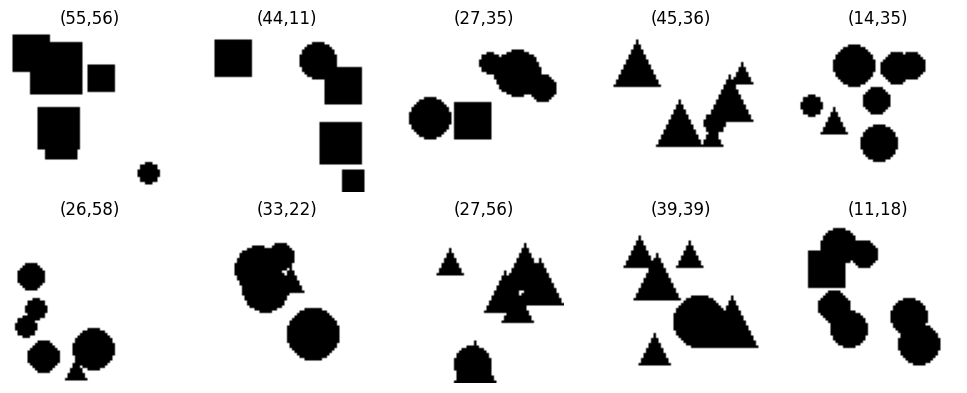

In [3]:
# ============================================================
# 0. Device
# ============================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================================
# 1. Online dataset: 64×64, target = (cx,cy) ∈ [0,63]²  (float32)
# ============================================================
IMAGE = 64
SHAPES = ("circle", "square", "triangle")

def draw_shape(drawer, shape_type, center_x, center_y, radius):
    if shape_type == "circle":
        drawer.ellipse([center_x - radius, center_y - radius,
                        center_x + radius, center_y + radius], fill="black")
    elif shape_type == "square":
        drawer.rectangle([center_x - radius, center_y - radius,
                          center_x + radius, center_y + radius], fill="black")
    else:  # triangle
        drawer.polygon([
            (center_x, center_y - radius),
            (center_x - radius, center_y + radius),
            (center_x + radius, center_y + radius)
        ], fill="black")

class OddXYDataset(Dataset):
    """
    Generates images on-the-fly:
      * several random shapes of the same type
      * 1 additional shape of a different type
    Returns:
      * image (1×64×64 tensor, float32 normalized to [0,1])
      * label: float tensor [cx, cy] with center of the odd shape
    Arguments:
        num_samples             – total number of samples in the dataset
        same_shape_count_range – tuple (min, max), number of identical shapes
        shape_radius_range      – tuple (min_radius, max_radius) for shape size
    """
    def __init__(self,
                 num_samples,
                 same_shape_count_range=(3, 6),
                 shape_radius_range=(4, 10)):
        self.num_samples = num_samples
        self.same_shape_count_range = same_shape_count_range
        self.radius_min, self.radius_max = shape_radius_range

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        base_shape = random.choice(SHAPES)
        odd_shape = random.choice([s for s in SHAPES if s != base_shape])

        img = Image.new("L", (IMAGE, IMAGE), "white")
        drawer = ImageDraw.Draw(img)

        # draw identical shapes
        for _ in range(random.randint(*self.same_shape_count_range)):
            radius = random.randint(self.radius_min, self.radius_max)
            cx = random.randint(radius, IMAGE - radius - 1)
            cy = random.randint(radius, IMAGE - radius - 1)
            draw_shape(drawer, base_shape, cx, cy, radius)

        # draw the odd shape (with known center)
        radius = random.randint(self.radius_min, self.radius_max)
        cx = random.randint(radius, IMAGE - radius - 1)
        cy = random.randint(radius, IMAGE - radius - 1)
        draw_shape(drawer, odd_shape, cx, cy, radius)

        img_tensor = torch.tensor(np.array(img), dtype=torch.float32).unsqueeze(0) / 255.
        label_tensor = torch.tensor([float(cx), float(cy)], dtype=torch.float32)
        return img_tensor, label_tensor

def show_examples(num_examples=10):
    """
    Displays a grid of image samples from OddXYDataset using a DataLoader with batch_size=1.

    Args:
        num_examples (int): Number of examples to display.
    """
    dataset = OddXYDataset(num_samples=num_examples)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    num_columns = 5
    num_rows = math.ceil(num_examples / num_columns)

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 2, num_rows * 2))

    for i, (image, label) in enumerate(dataloader):
        if i >= num_examples:
            break
        image_np = image.squeeze(0).squeeze(0).numpy()  # B=1,C=1,H,W --> H,W
        cx, cy = label.squeeze(0)                       # B=1,2       --> 2
        axes.flat[i].imshow(image_np, cmap="gray")
        axes.flat[i].set_title(f"({cx:.0f},{cy:.0f})")
        axes.flat[i].axis("off")

    for j in range(i + 1, num_rows * num_columns):
        axes.flat[j].axis("off")

    plt.tight_layout()
    plt.show()



show_examples()

## Załadowanie danych

Ustawiamy ziarno losowości

In [4]:
torch.manual_seed(439669)
torch.cuda.manual_seed(439669)
torch.cuda.manual_seed_all(439669)

Ustalenie danych do trenowania. Zbiór do walidacji był przydatny, żeby patrzeć jak sobie sieć automatycznie radzi przy trenowaniu (po treningu odpaliłem już wytrenowaną sieć i usunęło mi output z trenowania, to znaczy wyprintowane RMSE na epokę oraz stratę na zbiorze walidacyjnym, stąd może się to teraz wydawać niepotrzebne).

In [5]:
BATCH_SIZE = 64 #co tyle aktualizujemy gradienty
TRAIN_SAMPLES_PER_EPOCH = 25000 # 25k obrazków przerabimy na epokę
VAL_SAMPLES = 5000  #rozmiar zbioru walidacyjnego

train_dataset = OddXYDataset(num_samples=TRAIN_SAMPLES_PER_EPOCH) #zbiór trenigowy
val_dataset = OddXYDataset(num_samples=VAL_SAMPLES) #zbiór walidacyjny

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) #załadowanie zbioru treningowego do pytorcha
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False) #załadowanie zbioru walidacyjnego do pytorcha

## Trenowanie

#### Funkcja do wczytania modelu i wznowienia treningu od danej epoki

In [6]:
#Trenowanie sieci neuronowej trwało bardzo długo (około 2h na GPU), więc podczas trenowania tworzyłem checkpointy
#Poniższa funkcja ma na celu wczytanie wybranego checkpointa (czyli informacji i wag modelu w tym przypadku) i WZNOWIENIE TRENINGU

def load_checkpoint(net, optimizer, path):
    checkpoint = torch.load(path, map_location=device)
    net.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    #funkcja zapisywała też aktualną epokę, aby można było wrócić do procesu trenowania w dowolnym momencie
    start_epoch = checkpoint['epoch'] + 1 

    print(f"Załadowano checkpoint {path}, proces trenowania rozpocznie się od epoki: {start_epoch}")
    return start_epoch


#### Funkcja do trenowania sieci neurnowej

In [7]:
#ustalenie czy trenowanie będzie na GPU czy CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

#funckja do trenowania modelu
def train_model(net, train_loader, val_loader,
                epochs=100,
                lr=0.001,
                log_every=1,
                save_every=100,
                start_epoch = 0,
                checkpoint_dir="checkpoints",
                checkpoint_prefix="model"):
    
    #ustalenie folderu z checkpointami
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    #jaką sieć neurnową chcemy trenować
    net = net.to(device)

    #optymalizator oraz funkcja straty jaką używamy
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()

    #zapisywanie trajektorii do wykresu straty
    train_loss_history = []
    val_loss_history = []
    train_rmse_history = []
    val_rmse_history = []

    start_time = time.time()

    #proces trenowania
    for epoch in range(start_epoch, epochs):
        net.train()
        train_loss_sum = 0.0
        train_total = 0

        for batch_inputs, batch_labels in train_loader:
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device).float()

            optimizer.zero_grad()
            outputs = net(batch_inputs)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            train_loss_sum += loss.item() * batch_inputs.size(0)
            train_total += batch_inputs.size(0)

        avg_train_loss = train_loss_sum / train_total
        train_rmse = avg_train_loss ** 0.5
        train_loss_history.append(avg_train_loss)
        train_rmse_history.append(train_rmse)

        #Walidacja
        net.eval()
        val_loss_sum = 0.0
        val_total = 0

        #sprawdzenie wyników na zbiorze walidacyjnym
        #to się przydało do monitrowania procesu treningu
        with torch.no_grad():
            for batch_inputs, batch_labels in val_loader:
                batch_inputs = batch_inputs.to(device)
                batch_labels = batch_labels.to(device).float()

                outputs = net(batch_inputs)
                loss = criterion(outputs, batch_labels)

                val_loss_sum += loss.item() * batch_inputs.size(0)
                val_total += batch_inputs.size(0)

        avg_val_loss = val_loss_sum / val_total
        val_rmse = avg_val_loss ** 0.5
        val_loss_history.append(avg_val_loss)
        val_rmse_history.append(val_rmse)

        #Printowanie wyników
        if epoch % log_every == 0:
            print(f"Epoch {epoch:03d} | "
                  f"Train RMSE: {train_rmse:.4f} | Val RMSE: {val_rmse:.4f}")

        #Zapisanie checkpointu co jakiś czas (co jakąś epokę)
        if save_every and epoch % save_every == 0:
            ckpt_path = os.path.join(checkpoint_dir, f"{checkpoint_prefix}_epoch{epoch:03d}_new.pt")
            torch.save({
                'epoch': epoch,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_rmse': train_rmse,
                'val_rmse': val_rmse
            }, ckpt_path)
            print(f"Checkpoint saved to: {ckpt_path}")

    end_time = time.time()
    print(f"Training finished in {end_time - start_time:.2f} seconds")

    return train_loss_history, val_loss_history, train_rmse_history, val_rmse_history


Working on cuda


#### Funkcja do rysowania wykresów straty

In [8]:
def plot_training_curves(train_loss, val_loss, train_acc, val_acc):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    #Plottowanie straty
    axs[0].plot(train_loss, label="Train Loss", color='blue')
    axs[0].plot(val_loss, label="Val Loss", color='orange', alpha = 0.5)
    axs[0].set_title("Loss per Epoch")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Average Loss")
    axs[0].grid(True)
    axs[0].legend()

    #Plotowanie accuracy - u nas jest to niepotrzebne, ale zorientowałem się już po procesie treningu
    #Wobec tego w przypadku tego zadania accuracy to RMSE, a strata to MSE
    axs[1].plot(train_acc, label="Train Accuracy", color='red')
    axs[1].plot(val_acc, label="Val Accuracy", color='green', alpha = 0.5)
    axs[1].axhline(5, color="green", linestyle="--", linewidth=1)
    axs[1].text(
        0.95, 5.1, "RMSE = 5", color="green", fontsize=10,
        ha="right", va="bottom", transform=axs[1].get_yaxis_transform()
    )
    axs[1].set_title("Accuracy (RMSE) per Epoch")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

#### Funkcja do pokazania obrazków z bazy danych i narysowania przewidywanego centrum

In [9]:
def show_with_predictions(model, dataset, device, num_examples=10):
    model.eval()

    #ładujemy wybrane dane, tzn wybrane obrazki
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    num_columns = 5
    num_rows = math.ceil(num_examples / num_columns)

    #ustalenie wyglądu wykresu
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 2, num_rows * 2))

    #przewidujemy centrum (środek figury niepasującej do reszty)
    with torch.no_grad():
        for i, (image, label) in enumerate(dataloader):
            if i >= num_examples:
                break

            image = image.to(device)          # (1,1,64,64)
            label = label.squeeze(0).cpu().numpy()  # (2,)

            pred_coords = model(image)       # (1,2)
            pred_coords = pred_coords.squeeze(0).cpu().numpy()

            #Pokazujemy obrazek z przewidywanym środkiem figury niepasującej
            axes.flat[i].imshow(image.squeeze(0).squeeze(0).cpu(), cmap='gray')
            #zaznaczenie przewidywanego środka
            axes.flat[i].scatter(pred_coords[0], pred_coords[1], color='red', s=20, label='Przewidywany środek')
            #zaznaczenie prawdziwego środka
            axes.flat[i].scatter(label[0], label[1], color='green', s=20, label='Prawdziwy środek')
            axes.flat[i].set_title(f"True: ({label[0]:.0f},{label[1]:.0f})\nPred: ({pred_coords[0]:.1f},{pred_coords[1]:.1f})")

            axes.flat[i].axis('off')

    for j in range(i + 1, num_rows * num_columns):
        axes.flat[j].axis('off')

    plt.tight_layout()
    plt.show()

#### Rysowanie obrazków wraz z wizualizacją atencji

In [10]:
def show_attention_with_predictions(model, dataset, device, num_examples=10):
    model.eval() 
    # Tworzymy siatkę wykresów: dla każdego przykładu 2 kolumny (lewa: mapa atencji, prawa: obrazek z predykcją)
    fig, axes = plt.subplots(num_examples, 2, figsize=(8, num_examples * 3))

    # Iterujemy po wybranych przykładach
    for i in range(num_examples):
        img, _ = dataset[i]  # Pobieramy pojedynczy obraz i etykietę
        img = img.unsqueeze(0).to(device)  # Dodajemy wymiar wsadowy: (1, 1, 64, 64) i przenosimy na GPU/CPU

        with torch.no_grad(): 
            pred_coords = model(img)  # Predykcja współrzędnych środka figury (tensor: (1, 2))
            attn = model.attn.attention  # Wyciągamy macierz wag atencji z warstwy self-attention: shape (1, 144, 144)

        attn_np = attn.squeeze(0).cpu().numpy()  # Usuwamy wymiar wsadowy i przenosimy na CPU → (144, 144)
        attn_map = attn_np.mean(axis=0)  # Bierzemy średnią po wszystkich zapytaniach (query), aby uzyskać ogólną istotność każdego patcha

        # Zmieniamy wymiar wektora attencji na obrazek 12x12
        # ← wynika to z tego, że CNN-embedding używa kernel_size=20, stride=4, bez paddingu,
        # więc przekształca obraz 64x64 na 12x12 patchy, czyli 144 "tokenów" w atencji
        attn_map_img = attn_map.reshape(12, 12)  # Zamieniamy 144-elementowy wektor na siatkę patchy (12x12)

        # Wizualizacja mapy attencji
        ax1 = axes[i, 0]
        im = ax1.imshow(attn_map_img, cmap='hot')  # ← przechowujemy uchwyt do obrazu, by dodać colorbar
        ax1.set_title(f"Mapa attencji {i+1}")
        ax1.axis('off')
        plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)  # Dodajemy skalę kolorów do mapy attencji

        # Wizualizacja oryginalnego obrazka i przewidywanego środka figury
        ax2 = axes[i, 1]
        ax2.imshow(img.squeeze().cpu(), cmap='gray')  # Usuwamy dodatkowy wymiar (1,1,64,64) → (64,64)
        x, y = pred_coords[0].cpu().numpy()  # Współrzędne przewidywanego środka: (x, y)
        ax2.scatter(x, y, color='red', s=30)  # Zaznaczamy czerwonym punktem przewidywany środek
        ax2.set_title(f"Przewidywany środek {i+1}")
        ax2.axis('off')

    plt.tight_layout() 
    plt.show()


### Definicje sieci

In [11]:
embed_cnt = 16        # liczba kanałów po embeddingu przez CNN
pos_cnt = 16          # wymiar kodowania pozycyjnego
feature_cnt = 16      # wymiar cech patcha (także wyjściowy z attention)
k = 8                 # wymiar przestrzeni Q i K
d_v = feature_cnt     # wymiar wartości V (taki jak cechy)
num_patches = 144     # 12 x 12 = liczba patchy (dla 64x64 wejścia i stride=4)

## Opis architektury seici neuronowej do lokalizacji środka figury

Przy tworzeniu tej sieci neuronowej mocno zasugerowano się architekturą podaną przez prowadzącego. W tym celu przeprowadzono kroki opisane w pliku z labów numer 13.

**Kroki przetwarzania:**

1. **Patch embedding (CNN):**  
   Obraz dzielony jest na nakładające się patche za pomocą splotu `Conv2d`, który zamienia wejście (1×64×64) na 144 patchy z 16 kanałami cech każdy (kształt: 144×16).

2. **Kodowanie pozycyjne (sinusoidal):**  
   Do każdego patcha dodawane jest deterministyczne kodowanie pozycji, aby model mógł rozróżnić, gdzie dany patch się znajduje.

3. **Self-Attention:**  
   Każdy patch może „zwrócić uwagę” na inne, obliczając softmax z iloczynów skalarnych zapytań (Q) i kluczy (K). Wynikowy wektor cech patcha to suma ważona wartości (V) innych patchy.

4. **MLP Head + Soft-argmax:**  
   Dla każdego patcha obliczany jest logit, który reprezentuje prawdopodobieństwo, że patch zawiera środek figury. Następnie wyliczane jest uśrednione położenie środka jako **soft-argmax** po współrzędnych środków patchy (ważone softmaxem z logitów).

**Wyjście:** współrzędne (x, y) środka figury w przestrzeni obrazu.

In [12]:
# Positional encoding <- zapisane jako osobna klasa, ale robi to samo co jakbyś napisali jak na ćwiczeniach
class PositionalEncoding(nn.Module):
    def __init__(self, dim, max_len=144):
        super().__init__()
        pe = torch.zeros(max_len, dim)  # wymiar (144, 16)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)  # wymiar (144, 1)
        div_term = torch.exp(torch.arange(0, dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / dim))  # wymiar (dim/2,)
        pe[:, 0::2] = torch.sin(position * div_term)  # sinus dla parzystych indeksów
        pe[:, 1::2] = torch.cos(position * div_term)  # cosinus dla nieparzystych
        self.register_buffer('pe', pe.unsqueeze(0))  # wymiar (1, 144, 16)

    def forward(self, x):
        # Dodaje kodowanie pozycyjne do inputu x: (B, 144, 16)
        return x + self.pe[:, :x.size(1)]  # wymiar (B, 144, 16)

#Self-Attention
class SelfAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.Q = nn.Linear(feature_cnt, k)      # (16 → 8)
        self.K = nn.Linear(feature_cnt, k)      # (16 → 8)
        self.V = nn.Linear(feature_cnt, d_v)    # (16 → 16)
        self.attention = None                   # będzie mieć shape: (B, 144, 144)

    def forward(self, features):
        # features: (B, 144, 16) — wejściowe cechy patchy

        queries = self.Q(features)              # (B, 144, 8)
        keys = self.K(features)                 # (B, 144, 8)
        values = self.V(features)               # (B, 144, 16)

        # Attention weights: skalarny iloczyn zapytań i kluczy, podzielony przez sqrt(k)
        energies = queries @ keys.transpose(-2, -1) / (k ** 0.5)  # (B, 144, 144)

        # Softmax po ostatnim wymiarze (nadaje wagi wyjściowe dla każdego patcha)
        self.attention = F.softmax(energies, dim=-1)              # (B, 144, 144)

        # Wyjście: attention @ values → (B, 144, 16)
        return self.attention @ values

#Główna sieć neuronowa
class VisionTransformerForLocalization(nn.Module):
    def __init__(self):
        super().__init__()

        # CNN jako patch embedding: 64x64 → 12x12 patchy
        self.embed = nn.Conv2d(1, feature_cnt, kernel_size=20, stride=4, padding=0)
        # wyjście: (B, 16, 12, 12)

        # Kodowanie pozycyjne dodawane do patchy (wektorów o wymiarze 16)
        self.pos_encoding = PositionalEncoding(dim=feature_cnt, max_len=num_patches)

        # Normalizacja cech patcha przed atencją (LayerNorm per patch) <- podzielnie przez sqrt(k)
        self.norm = nn.LayerNorm(feature_cnt)

        # Warstwa self-attention
        self.attn = SelfAttention()

        #Post proccesing <- dwuwartsowe MLP + GELU
        #zastosowano GELU, jako "gładszą" formę "RELU" co pozwala na lepszy proces treningu
        self.mlp_head = nn.Sequential(
            nn.Linear(feature_cnt, 32),  # (16 → 32)
            nn.GELU(),
            nn.Linear(32, 1)             # (32 → 1)
        )

        # Współrzędne środków patchy na siatce 12x12
        self.register_buffer("grid_centers", self._make_grid_centers())  # shape: (144, 2)

    def _make_grid_centers(self):
        # Tworzy współrzędne środków patchy: (x, y) w pikselach
        centers = []
        for i in range(12):
            for j in range(12):
                x = 10 + 4 * j  # środek patcha w poziomie (os X)
                y = 10 + 4 * i  # środek patcha w pionie (os Y)
                centers.append([x, y])
        return torch.tensor(centers).float()  # shape: (144, 2)

    def forward(self, x):
        # Wejście: obraz (B, 1, 64, 64)
        B = x.shape[0]

        #Krok 1: patch embedding przez CNN
        x = self.embed(x)                  # (B, 16, 12, 12)
        x = x.flatten(2).transpose(1, 2)   # (B, 144, 16) — 144 patchy, 16 cech każdy

        #kodowanie pozycyjne + normalizacja
        x = self.norm(x)                   # (B, 144, 16)
        x = self.pos_encoding(x)          # (B, 144, 16)

        #Krok 3: self-attention
        x = self.attn(x)                   # (B, 144, 16)

        #Krok 4: klasyfikacja tokenów przez MLP
        logits = self.mlp_head(x).squeeze(-1)  # (B, 144)

        #Krok 5: softmax + soft-argmax
        probs = F.softmax(logits / 0.5, dim=-1)          # (B, 144) — rozkład po patchach
        pred_coords = torch.einsum("bp,pc->bc", probs, self.grid_centers)  # (B, 2)

        return pred_coords  # przewidywane współrzędne środka figury (x, y)


### Trenowanie modelu
Przy zadanej architekturze sieć trenowała się na moim komputerze około 2h. Poniższy kawałek kodu trenuje sieć neuronową i zapisuje co jakiś czas wyniki. W procesie treningu wykonano 2500 epok (każda epoka to przetworzenie 25k obrazów) co skutkowało uzyskaniem RMSE na poziomie około 4.64. Najlepszy okazał się model zatrzymany po 2400 epokach i ten model jest dalej wykorzystany w tym pliku.

Poniższą linijkę można odkomentować, aby samodzielnie przeprowadzić proces trenowania.

In [13]:
# model = VisionTransformerForLocalization()

# train_loss_hist, val_loss_hist, train_rmse_hist, val_rmse_hist = train_model(
#     model, train_loader, val_loader, epochs=2500, lr=0.001, log_every= 1
# )

Wykres wartości funkcji straty pochodzi z powyższego procesu treningu. Przedstawione są dwa wykresy. W procesie treningu wykorzystano MSE (zgodnie z poleceniem) a następnie przyglądano się RMSE. Dopiero po procesie treningu zorientowałem się, że przyjąłem złe nazewnictwo na wykresach, więc proszę je zignorować. Po lewej stronie znajduje się wykres MSE przy poszczególnych epokach. Po prawej stronie jest wykres RMSE przy poszczególnych epokach. Zieloną przerywaną linią zaznaczono poziom, który należało osiągnąć w tym zadaniu. Niestety kolor czerwony - kolor na zbiorze walidacyjnym przykrył wykres z procesu treningu, za co przepraszam, ale nie chciałem powtarzać kolejny raz procesu trenowania.

<img src="https://raw.githubusercontent.com/tomczj/ML24_25/main/NLP_self_attention/learning_curve.png">

In [14]:
# plot_training_curves(train_loss_hist, val_loss_hist, train_rmse_hist, val_rmse_hist)

W tym pliku nie przeprowadzamy procesu treningu tylko ładujemy wytrenowaną wcześniej sieć neuronową.

In [ ]:
# URL modelu
url = "https://raw.githubusercontent.com/tomczj/ML24_25/main/NLP_self_attention/model_epoch2400.pt"

os.makedirs("checkpoint", exist_ok=True)

filename = "checkpoint/model_epoch2400_cur.pt"
response = requests.get(url)
response.raise_for_status()

with open(filename, "wb") as f:
    f.write(response.content)

print("Model saved to", filename)


In [ ]:
#Inicjalizacja modelu
model = VisionTransformerForLocalization()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#Załadowanie modelu z wybranego checkpointa
checkpoint = torch.load("checkpoints/model_epoch2400_cur.pt", map_location=device)

# Ładujemy wagi
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()


VisionTransformerForLocalization(
  (embed): Conv2d(1, 16, kernel_size=(20, 20), stride=(4, 4))
  (pos_encoding): PositionalEncoding()
  (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (attn): SelfAttention(
    (Q): Linear(in_features=16, out_features=8, bias=True)
    (K): Linear(in_features=16, out_features=8, bias=True)
    (V): Linear(in_features=16, out_features=16, bias=True)
  )
  (mlp_head): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)

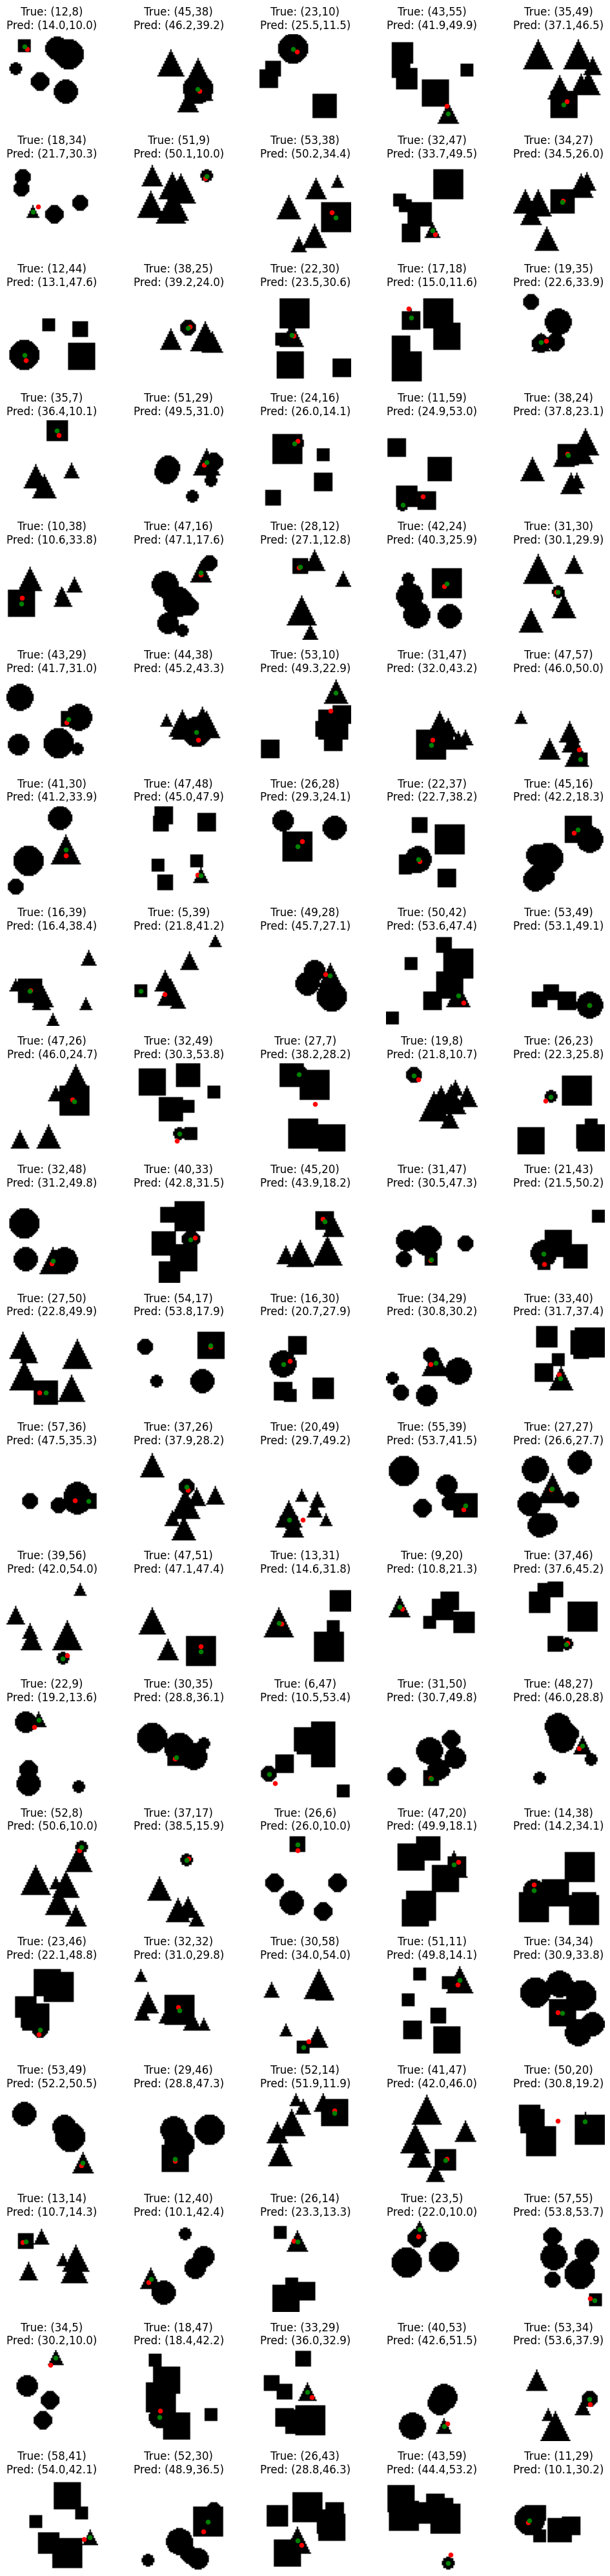

In [16]:
#Wybieramy 100 obrazków do wizualizacji działania sieci neuronowej
dataset = OddXYDataset(num_samples=100)
#Pokazujemy rzeczywsity środek i przewidywany środek niepasującej figury
show_with_predictions(model, dataset, device, num_examples=100)

### Mapy (heat-mapy) self-attention

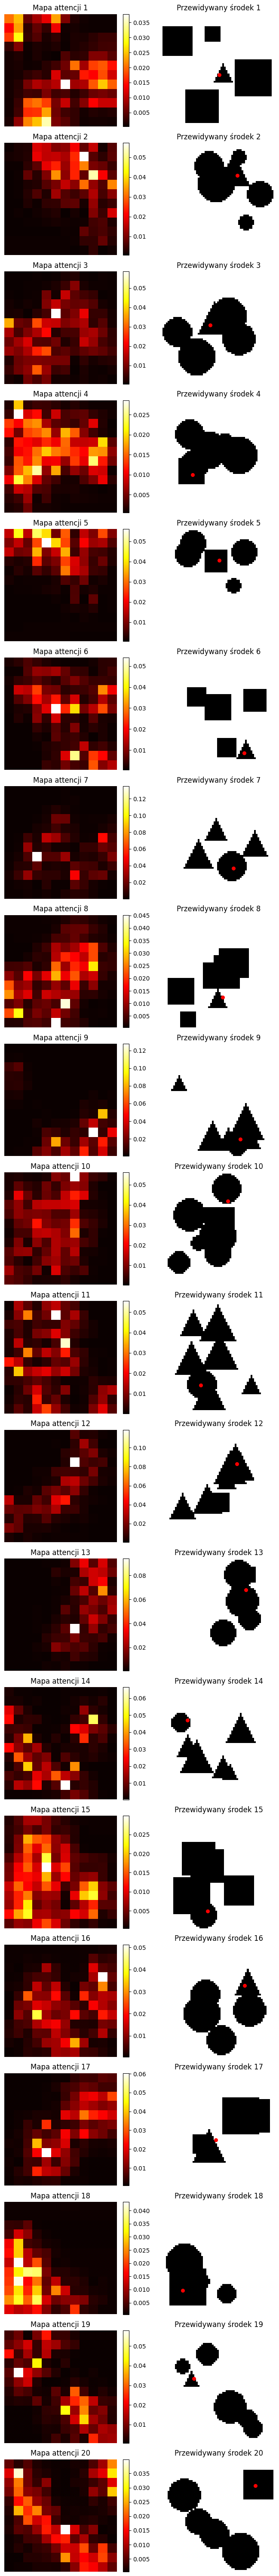

In [17]:
dataset = OddXYDataset(num_samples=20)  #obrazki do pokazania

#pokazanie heatmap self-attention
show_attention_with_predictions(model, dataset, device, num_examples=20)


# Omówienie wyników

## Opis rozwiązania

Zaimplementowana sieć neuronowa została zaprojektowana w celu lokalizacji środka jednej figury niepasującej w wygenerowanym syntetycznie obrazku 64×64 w skali szarości. Sieć osiąga bardzo dobrą skuteczność w tym zadaniu, czego potwierdzeniem jest **RMSE poniżej 5.0 piksela** na zbiorze testowym (25 000 próbek).

### Architektura modelu

Architektura sieci składa się z trzech głównych komponentów:

1. **Ekstrakcja cech (patch embedding)**: wejściowy obraz `(1, 64, 64)` jest przekształcany przez konwolucję z `kernel_size=20`, `stride=4`, `padding=0`, co daje wyjście o rozmiarze `(16, 12, 12)`. Każdy z 12×12 patchy reprezentowany jest przez 16-wymiarowy wektor cech.

2. **Self-attention**: dane są następnie podawane do warstwy pełnej atencji (multihead attention bez maskowania), w której 144 tokeny (czyli 12×12) oddziałują między sobą. Pozwala to sieci globalnie analizować zależności między różnymi obszarami obrazu, nawet przy prostym modelu.

3. **Regresja współrzędnych**: wyjście atencji `(1, 144, 16)` jest agregowane przez średnie uśrednienie po tokenach i przekazywane do warstw gęstych, które przewidują `(x, y) ∈ [0, 64]^2` — współrzędne środka szukanej figury.

### Wydajność i błędy modelu

Model ogólnie dobrze lokalizuje środki figur. Szczególnie skuteczny jest w przypadkach, gdy figura znajduje się bliżej środka obrazu. Wynika to bezpośrednio z ograniczeń embeddingu: po konwolucji pojedynczy patch "widzi" jedynie lokalny fragment obrazu, a więc rogi lub brzegi są reprezentowane mniej precyzyjnie. Ponieważ atencja działa na wektorach w przestrzeni 16-wymiarowej (zamiast na surowych pikselach), trudniej jest efektywnie uwzględnić skrajne obszary.

Dodatkowo zauważono, że skuteczność modelu spada, gdy na obrazku znajduje się wiele figur — nawet jeśli nie nachodzą one na tę niepasującą. Wiąże się to zapewne z trudnością w dekonfliktowaniu informacji między podobnymi regionami (np. wiele podobnych obiektów przyciąga uwagę sieci). W takich przypadkach obserwujemy wzrost błędu predykcji, co zostało zilustrowane na wizualizacjach.

### Mapy atencji i interpretacja

Aby lepiej zrozumieć działanie modelu, wygenerowano mapy atencji (`12×12`), które pokazują, na które fragmenty obrazu sieć zwraca największą uwagę. Obszary ciemne (bliskie czerni) wskazują brak zainteresowania (np. tło), natomiast czerwone i żółte fragmenty odpowiadają miejscom, na które sieć kieruje swoje „spojrzenie”.

W wielu przypadkach można zauważyć, że:

- najbardziej czerwone regiony odpowiadają obecności dowolnych figur,
- najjaśniejsze (żółtawe, białawe) pola często są umiejscowione w pobliżu środka niepasującej figury,
- niekiedy nawet jeśli środek nie znajduje się bezpośrednio w najjaśniejszym miejscu mapy, to model i tak poprawnie go lokalizuje — co świadczy o pewnej tolerancji i uogólnieniu wzorców.

Należy jednak pamiętać, że mapa atencji jest znacznie bardziej zgrubna niż sam obrazek (`12×12` vs `64×64`), co wprowadza naturalne ograniczenia w precyzji lokalizacji. Mimo to, sieć potrafi odpowiednio przetwarzać i wnioskować na ich podstawie.
